In [2]:
import spacy
from spacy.tokens import Doc, Span
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('dbpedia_spotlight', config={'confidence': 0.35})
from fastcoref import LingMessCoref
model = LingMessCoref()
from SPARQLWrapper import SPARQLWrapper, JSON
from datasets import load_dataset
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
import os
from tqdm.notebook import tqdm
import concurrent.futures
max_doc_length = 4096
import re
from spacy.lang.en.stop_words import STOP_WORDS

06/10/2024 10:21:27 - INFO - 	 missing_keys: []
06/10/2024 10:21:27 - INFO - 	 unexpected_keys: []
06/10/2024 10:21:27 - INFO - 	 mismatched_keys: []
06/10/2024 10:21:27 - INFO - 	 error_msgs: []
06/10/2024 10:21:27 - INFO - 	 Model Parameters: 590.0M, Transformer: 434.6M, Coref head: 155.4M


In [3]:
def preprocess_text(text):
    # Normalize case
    text = text.lower()
    
    # Clean text
    text = re.sub(r'[^\w\s.]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # # # Remove stop words
    # doc = nlp(text)
    # tokens = [token.text for token in doc if token.text.lower() not in STOP_WORDS]
    # text = ' '.join(tokens)
    
    return text

def get_cluster_spans(doc, clusters):
    fast_clusters = []
    for cluster in clusters:
        new_group = []
        for start, end in cluster:
            span = doc.char_span(start, end)
            if span is not None:
                new_group.append([span.start, span.end - 1])
        fast_clusters.append(new_group)
    return fast_clusters

def get_clusters(doc, text):
    preds = model.predict(texts=[text])
    # print(f"\nThe clusters of same entities are as follows: {preds[0].get_clusters(as_strings=True)} \n")
    clusters = preds[0].get_clusters(as_strings=False)
    cluster_spans = get_cluster_spans(doc, clusters)
    return cluster_spans

def get_span_noun_indices(doc, cluster):    
    spans = [doc[start:end+1] for start, end in cluster]

    spans_pos = []
    for span in spans:
        pos_tags = [token.pos_ for token in span]
        spans_pos.append(pos_tags)

    noun_indices = []
    for i, pos_list in enumerate(spans_pos):
        if 'NOUN' in pos_list or 'PROPN' in pos_list:
            noun_indices.append(i)
    return noun_indices

def get_cluster_head(doc, cluster, noun_indices):
    head_idx = noun_indices[0]
    head_start, head_end = cluster[head_idx]
    head_span = doc[head_start:head_end+1]
    return head_span, [head_start, head_end]

def is_containing_other_spans(span, all_spans):
    for s in all_spans:
        if s[0] >= span[0] and s[1] <= span[1] and s != span:
            return True  
    return False

def replacement(coref, resolved, mention_span):
    start, end = coref
    mention_text = mention_span.text_with_ws 
    resolved[start] = mention_text
    for i in range(start + 1, end + 1):
        resolved[i] = ""
    return resolved

def replace_corefs(document, clusters):
    resolved = [token.text_with_ws for token in document]
    all_spans = [span for cluster in clusters for span in cluster]

    for cluster in clusters:
        noun_indices = get_span_noun_indices(document, cluster)

        if noun_indices:
            mention_span, mention = get_cluster_head(document, cluster, noun_indices)
        else:
            start, end = cluster[0]
            mention_span = document[start:end+1]
            mention = cluster[0]
            
        for coref in cluster:
            if coref != mention and not is_containing_other_spans(coref, all_spans):
                resolved = replacement(coref, resolved, mention_span)

    
    return ("".join(resolved))


def coreference_resolution(text):
    text = text.replace('"', '')
    text = text.replace('\'', '')
    doc = nlp(text)
    clusters = get_clusters(doc, text) 
    answer= replace_corefs(doc, clusters) 
    return answer

def get_sentence_based_links(text):
    final_text = coreference_resolution(text)
    doc = nlp(final_text)
    sentence_forms = []
    for sent in doc.sents:
        entities_set = set()  
        entities = []  
        for ent in sent.ents:
            # print(ent)
            if ent.kb_id_ != "" and ent.kb_id_ not in entities_set:
                entities.append(ent.kb_id_)
                entities_set.add(ent.kb_id_)
        sentence_forms.append(entities)
        # sentence_forms.append([ent.kb_id_ for ent in sent.ents if ent.kb_id_ != ""])
    pairs = []
    count = 0
    for entities in sentence_forms:
        if len(entities)>1:
            for i in range(len(entities)):
                for j in range(i+1,len(entities)):
                    pairs.append([entities[i],entities[j]])
                    count+=1
    print(f"The number of pairs is: {count}\n")
    
    return pairs,final_text

def check_direct_link(source_target):
    source_uri, target_uri = source_target
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    sparql.setMethod('POST')  
    
    query_source_to_target = f"""
    ASK WHERE {{
      <{source_uri}> ?p <{target_uri}> .
    }}
    """
    sparql.setQuery(query_source_to_target)
    sparql.setReturnFormat(JSON)

    try:
        result_source_to_target = sparql.query().convert()
        has_link_source_to_target = result_source_to_target['boolean']
    except Exception as e:
        print(f"Error querying {source_uri} -> {target_uri}: {e}")
        has_link_source_to_target = False

    # Query from target to source
    query_target_to_source = f"""
    ASK WHERE {{
      <{target_uri}> ?p <{source_uri}> .
    }}
    """
    sparql.setQuery(query_target_to_source)

    try:
        result_target_to_source = sparql.query().convert()
        has_link_target_to_source = result_target_to_source['boolean']
    except Exception as e:
        print(f"Error querying {target_uri} -> {source_uri}: {e}")
        has_link_target_to_source = False

    # Combine the results
    has_link = has_link_source_to_target or has_link_target_to_source
    return source_uri, target_uri, has_link

    
def count_direct_links_and_fraction(text, num_workers=50):
    pairs,final_text = get_sentence_based_links(text)
    
    if not pairs:
        print("No entity pairs found.")
        return -1,[],[],final_text
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(check_direct_link, pair): pair for pair in pairs}
        
        results = []
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                source_target = futures[future]
                print(f"Error processing pair {source_target}: {e}")
    
    direct_links = [1 if has_link else 0 for _, _, has_link in results]
    direct_links_count = sum(direct_links)
    
    fraction = -1
    if(len(pairs)>0):
        fraction = direct_links_count/len(pairs)
    
    return fraction, pairs, direct_links, final_text

# #test =  ["John Russell Reynolds (1820–1876) was an English lawyer, judge, and author.", "He was born in London, the son of a barrister, and was educated at Eton College and Trinity College, Cambridge.", "He was called to the bar in 1845, and became a Queen's Counsel in 1859.", "He was appointed a judge of the Court of Common Pleas in 1867, and was knighted in 1871.", "Reynolds was a prolific author, writing on a wide range of topics.", "He wrote several books on legal topics, including The Law of Libel and Slander (1863), The Law of Copyright (1865), and The Law of Patents for Inventions (1868).", "He also wrote on a variety of other topics, including history, biography, and literature.", "He was a frequent contributor to the Saturday Review, and wrote several books on Shakespeare, including The Mystery of William Shakespeare (1848) and The Authorship of Shakespeare (1875).", "He also wrote a biography of the poet John Keats (1848)." ]
# test = [ "Gordon David Strachan (born 9 February 1957) is a Scottish football manager and former player.", "He is the manager of the Scotland national team.", "Strachan played for Dundee, Aberdeen, Manchester United, Leeds United and Coventry City, as well as the Scotland national team.", "He has also managed Coventry City, Southampton, Celtic and Middlesbrough.", "Strachan began his managerial career at Coventry City in 1996, leading them to the 1997 FA Cup Final, where they lost to Tottenham Hotspur.", "He then moved to Southampton in 2001, where he guided them to the 2003 FA Cup Final, which they lost to Arsenal.", "In 2005, he was appointed manager of Celtic, where he won three consecutive Scottish Premier League titles and the Scottish League Cup twice.", "He left Celtic in 2009 and was appointed manager of Middlesbrough in October 2010.", "He left Middlesbrough in October 2013.", "In January 2013, Strachan was appointed manager of the Scotland national team.", "He has since led Scotland to the UEFA Euro 2016 qualifying playoffs, where they were eliminated by eventual finalists, and to the 2018 FIFA World Cup" ]
# text = ""
# for i in test:
#    text += " " + i
# print(text)

# #text = "Claims of justification rest both on norms that permit the nominal commission of offenses and the perception of facts that support the application of the norm. The simplest justification is consent, for which the norm is simply whether the intended victim wants or desires the defendant's conduct to occur. Slightly more complicated is self-defense which requires three objective elements: (1) an actual attack, (2) a minimally necessary response, and (2) and a relationship of proportionality between the threatened interest and the harm done."

# start_time = time.time()
# print(count_direct_links_and_fraction(text))
# end_time = time.time()

# print(end_time - start_time)

# def number_of_direct_links_in_dbpedia(text):
#     pairs = get_sentence_based_links(text)
#     number_of_pairs = len(pairs)
#     existing_links = 0
    
#     for i in tqdm(range(len(pairs)), desc="Processing entries", unit="entry"):
#         if(check_direct_link(pairs[i][0], pairs[i][1])):
#             existing_links= existing_links+1
    
#     fraction = -1
#     if(number_of_pairs>0):
#         fraction = existing_links/number_of_pairs
#     print(f"The fraction of correct links = {fraction}")
#     return fraction


def check_i_th_entry_in_database(i):
    sentences = dataset["evaluation"][i]["gpt3_text"]
    ground_truth = dataset["evaluation"][i]["wiki_bio_text"]
    annotation = dataset["evaluation"][i]["annotation"]

    ground_truth_pairs = get_sentence_based_links(ground_truth)
    sentence_pairs = get_sentence_based_links(sentences)
    
    fraction = -1; 
    count = len(sentence_pairs)
    match = 0
    for pair in sentence_pairs:
        temp = [pair[1],pair[0]]
        if pair in ground_truth_pairs or temp in ground_truth_pairs:
            match+=1
    if(count!=0):
        fraction=match/count
    return sentences, ground_truth,fraction,annotation,sentence_pairs,ground_truth_pairs
  
def write_entries_to_files(entries, folder_name="Self_GPT_Testing"):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    for i, entry in enumerate(entries):
        filename = os.path.join(folder_name, f"entry_{i+1}.txt")
        with open(filename, 'w') as file:
            file.write("#############GROUND_PAIRS############\n\n")
            for x in entry[5]:
                file.write(f"{x[0]} and {x[1]}\n\n")
            file.write("#############SENTENCE_PAIRS############\n\n")
            for x in entry[4]:
                file.write(f"{x[0]} and {x[1]}\n\n")
            file.write("%%%%%%%%%%%%%%%%%%%%SENTENCES%%%%%%%%%%%%%%%%%\n")
            file.write(entry[0])
            file.write("\n\n")
            file.write("%%%%%%%%%%%%%%%%%%%%GROUND_TRUTH%%%%%%%%%%%%%%%\n")
            file.write(entry[1])
            file.write("\n\n")
            file.write("%%%%%%%%%%%%%%%%%%%%FRACTIONS%%%%%%%%%%%%%%%%%%\n")
            file.write(f"{entry[2]}")
            file.write("\n\n")
            file.write("%%%%%%%%%%%%%%%%%%%%ANNOTATIONS%%%%%%%%%%%%%%%%\n")
            for i in entry[3]:
                file.write(f"{i} ")
            file.write("\n\n")

In [4]:
checking = []
correct_scores = []
incorrect_scores = []

In [21]:
folder_name="Self_GPT_Testing"

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

for i in tqdm(range(82,136), desc="Processing entries", unit="entry"):
    sentences = preprocess_text(dataset["evaluation"][i]["gpt3_text"])
    ground_truth = preprocess_text(dataset["evaluation"][i]["wiki_bio_text"])
    annotation = dataset["evaluation"][i]["annotation"]
    
    sentences_score, sentence_pairs, sentence_links, sentence_coref_resolved= count_direct_links_and_fraction(sentences)
    
    correct_count = annotation.count("accurate") + annotation.count("minor_inaccurate")
    incorrect_count = annotation.count("major_inaccurate")
    total = len(annotation)
    if(correct_count==total):
        correct_scores.append(sentences_score)
    if(incorrect_count/total>0.80):
        incorrect_scores.append(sentences_score)
        
    filename = os.path.join(folder_name, f"entry_{i+1}.txt")
    with open(filename, 'w') as file:
        file.write("#############SENTENCE_PAIRS############\n\n")
        for i in range(len(sentence_pairs)):
            file.write(f"{sentence_pairs[i][0]} and {sentence_pairs[i][1]} and the value is : {sentence_links[i]}\n")
        file.write("\n\n")
        file.write("#############GROUND_PAIRS############\n\n")
        for i in range(len(ground_pairs)):
            file.write(f"{ground_pairs[i][0]} and {ground_pairs[i][1]} and the value is : {ground_links[i]}\n")
        file.write("\n\n")
        file.write("%%%%%%%%%%%%%%%%%%%%SENTENCES%%%%%%%%%%%%%%%%%\n")
        file.write(f"Sentences : \n{sentences} \n\n")
        file.write(f"Coref Resolved : \n{sentence_coref_resolved}")
        file.write("\n\n")
        file.write("%%%%%%%%%%%%%%%%%%%%GROUND_TRUTH%%%%%%%%%%%%%%%\n")
        file.write(f"Ground Truth : \n{ground_truth} \n\n")
        file.write(f"Coref Resolved : \n{ground_coref_resolved}")
        file.write("\n\n")
        file.write("%%%%%%%%%%%%%%%%%%%%FRACTIONS%%%%%%%%%%%%%%%%%%\n")
        file.write(f"Value for sentences is : {sentences_score} and for ground truth is : {ground_truth_score}")
        file.write("\n\n")
        file.write("%%%%%%%%%%%%%%%%%%%%ANNOTATIONS%%%%%%%%%%%%%%%%\n")
        for i in annotation:
            file.write(f"{i} ")
        file.write("\n\n")

Processing entries:   0%|          | 0/54 [00:00<?, ?entry/s]

06/10/2024 11:55:25 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:55:25 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 11



06/10/2024 11:55:31 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:55:31 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 144

The ground truth scores are: 0.06944444444444445



06/10/2024 11:55:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:55:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 69



06/10/2024 11:55:54 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:55:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 64

The ground truth scores are: 0.15625



06/10/2024 11:56:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:56:02 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 24



06/10/2024 11:56:08 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:56:08 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 128

The ground truth scores are: 0.140625



06/10/2024 11:56:22 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:56:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 31



06/10/2024 11:56:28 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:56:28 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 91

The ground truth scores are: 0.07692307692307693



06/10/2024 11:56:38 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:56:38 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 39



06/10/2024 11:56:44 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:56:44 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 43

The ground truth scores are: 0.18604651162790697



06/10/2024 11:56:50 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:56:50 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 14



06/10/2024 11:56:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:56:56 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 21

The ground truth scores are: 0.14285714285714285



06/10/2024 11:57:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:57:02 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 33



06/10/2024 11:57:08 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:57:08 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 262

The ground truth scores are: 0.05343511450381679



06/10/2024 11:57:26 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:57:27 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 31



06/10/2024 11:57:38 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:57:38 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 101

The ground truth scores are: 0.18811881188118812



06/10/2024 11:57:49 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:57:49 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 21



06/10/2024 11:57:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:57:56 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 76

The ground truth scores are: 0.2236842105263158



06/10/2024 11:58:04 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:58:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 48



06/10/2024 11:58:10 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:58:10 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 14

The ground truth scores are: 0.42857142857142855



06/10/2024 11:58:16 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:58:16 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 35



06/10/2024 11:58:24 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:58:24 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 76

The ground truth scores are: 0.23684210526315788



06/10/2024 11:58:32 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:58:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 24



06/10/2024 11:58:39 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:58:39 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 47

The ground truth scores are: 0.46808510638297873



06/10/2024 11:58:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:58:46 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 56



06/10/2024 11:58:54 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:58:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 67

The ground truth scores are: 0.3582089552238806



06/10/2024 11:59:03 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:59:03 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 42



06/10/2024 11:59:09 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:59:09 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 50

The ground truth scores are: 0.2



06/10/2024 11:59:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:59:16 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 39



06/10/2024 11:59:22 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:59:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 59

The ground truth scores are: 0.03389830508474576



06/10/2024 11:59:30 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:59:30 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 64



06/10/2024 11:59:39 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:59:39 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 26

The ground truth scores are: 0.23076923076923078



06/10/2024 11:59:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:59:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 56



06/10/2024 11:59:54 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 11:59:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 106

The ground truth scores are: 0.24528301886792453



06/10/2024 12:00:06 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:00:06 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 23



06/10/2024 12:00:13 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:00:13 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 52

The ground truth scores are: 0.23076923076923078



06/10/2024 12:00:22 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:00:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 33



06/10/2024 12:00:28 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:00:28 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 67

The ground truth scores are: 0.22388059701492538



06/10/2024 12:00:37 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:00:37 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 26



06/10/2024 12:00:43 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:00:43 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 91

The ground truth scores are: 0.0989010989010989



06/10/2024 12:00:53 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:00:53 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 36



06/10/2024 12:01:00 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:01:00 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 60

The ground truth scores are: 0.11666666666666667



06/10/2024 12:01:09 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:01:09 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 27



06/10/2024 12:01:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:01:15 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 105

The ground truth scores are: 0.2857142857142857



06/10/2024 12:01:27 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:01:27 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 47



06/10/2024 12:01:34 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:01:34 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 116

The ground truth scores are: 0.47413793103448276



06/10/2024 12:01:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:01:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 89



06/10/2024 12:01:55 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:01:55 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 103

The ground truth scores are: 0.06796116504854369



06/10/2024 12:02:05 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:02:05 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 20



06/10/2024 12:02:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:02:11 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 81

The ground truth scores are: 0.19753086419753085



06/10/2024 12:02:20 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:02:20 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 14



06/10/2024 12:02:27 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:02:27 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 140

The ground truth scores are: 0.12857142857142856



06/10/2024 12:02:39 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:02:39 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 26



06/10/2024 12:02:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:02:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 60

The ground truth scores are: 0.1



06/10/2024 12:02:54 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:02:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 67



06/10/2024 12:03:06 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:03:06 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 79

The ground truth scores are: 0.06329113924050633



06/10/2024 12:03:16 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:03:16 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 36



06/10/2024 12:03:23 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:03:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 141

The ground truth scores are: 0.12056737588652482



06/10/2024 12:03:35 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:03:35 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 37



06/10/2024 12:03:43 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:03:43 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 184

The ground truth scores are: 0.043478260869565216



06/10/2024 12:03:57 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:03:58 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 16



06/10/2024 12:04:04 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:04:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 14

The ground truth scores are: 0.2857142857142857



06/10/2024 12:04:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:04:11 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 76



06/10/2024 12:04:20 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:04:20 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 39

The ground truth scores are: 0.1282051282051282



06/10/2024 12:04:26 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:04:26 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 14



06/10/2024 12:04:32 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:04:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 39

The ground truth scores are: 0.15384615384615385



06/10/2024 12:04:39 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:04:39 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 105

Error querying http://dbpedia.org/resource/Véra_Korène -> http://dbpedia.org/resource/Louveciennes: <urlopen error [Errno 60] Operation timed out>
Error querying http://dbpedia.org/resource/Filmmaking -> http://dbpedia.org/resource/Comédie-Française: <urlopen error [Errno 60] Operation timed out>


06/10/2024 12:04:52 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:04:52 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 206

The ground truth scores are: 0.043689320388349516



06/10/2024 12:05:09 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:05:09 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 45



06/10/2024 12:05:16 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:05:16 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 68

The ground truth scores are: 0.058823529411764705



06/10/2024 12:05:25 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:05:25 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 94



06/10/2024 12:05:35 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:05:35 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 128

The ground truth scores are: 0.203125



06/10/2024 12:05:48 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:05:48 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 34



06/10/2024 12:05:55 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:05:55 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 89

The ground truth scores are: 0.11235955056179775



06/10/2024 12:06:10 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:06:10 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 74



06/10/2024 12:06:18 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:06:18 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 160

The ground truth scores are: 0.2



06/10/2024 12:06:33 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:06:33 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 47



06/10/2024 12:06:41 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:06:41 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 31

The ground truth scores are: 0.1935483870967742



06/10/2024 12:06:51 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:06:51 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 50



06/10/2024 12:06:59 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:06:59 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 40

The ground truth scores are: 0.4



06/10/2024 12:07:05 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:07:06 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 58



06/10/2024 12:07:14 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:07:14 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 59

The ground truth scores are: 0.3220338983050847



06/10/2024 12:07:22 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:07:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 54



06/10/2024 12:07:32 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:07:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 47

The ground truth scores are: 0.0851063829787234



06/10/2024 12:07:38 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:07:38 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 29



06/10/2024 12:07:44 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:07:44 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 50

The ground truth scores are: 0.08



06/10/2024 12:07:52 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:07:52 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 16



06/10/2024 12:07:59 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:07:59 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 136

The ground truth scores are: 0.11764705882352941



06/10/2024 12:08:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:08:15 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 92



06/10/2024 12:08:24 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:08:24 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 386

The ground truth scores are: 0.13730569948186527



06/10/2024 12:08:52 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:08:52 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 45



06/10/2024 12:08:59 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:08:59 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 81

The ground truth scores are: 0.25925925925925924



06/10/2024 12:09:08 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:08 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 44



06/10/2024 12:09:14 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:14 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 41

The ground truth scores are: 0.21951219512195122



06/10/2024 12:09:20 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:20 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 34



06/10/2024 12:09:26 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:26 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 12

The ground truth scores are: 0.4166666666666667



06/10/2024 12:09:32 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 16



06/10/2024 12:09:38 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:38 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 22

The ground truth scores are: 0.5



06/10/2024 12:09:44 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:44 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 45



06/10/2024 12:09:50 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:50 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 13

The ground truth scores are: 0.15384615384615385



06/10/2024 12:09:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:09:56 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 33



06/10/2024 12:10:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:10:02 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 86

The ground truth scores are: 0.03488372093023256



06/10/2024 12:10:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:10:11 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 41



06/10/2024 12:10:18 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:10:18 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 67

The ground truth scores are: 0.1044776119402985



06/10/2024 12:10:27 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:10:27 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 72



06/10/2024 12:10:35 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:10:35 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 155

The ground truth scores are: 0.16774193548387098



06/10/2024 12:10:48 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:10:49 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 121



06/10/2024 12:11:01 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 12:11:01 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 229

The ground truth scores are: 0.314410480349345



In [22]:
print(correct_scores)

[0.0625, 0.1103448275862069, 0.03581267217630854, 0.0995850622406639, 0.4489795918367347, 0.18604651162790697, 0.09615384615384616, 0.02717391304347826, 0.1724137931034483, 0.08333333333333333, 0.26, 0.125, 0.3333333333333333, 0.13333333333333333, 0.18604651162790697, 0.26744186046511625, 0.22857142857142856, 0.07142857142857142, 0.08527131782945736, 0.3333333333333333, 0.1527777777777778, 0.10256410256410256, 0.0, 0.029288702928870293, 0.25274725274725274, 0.17857142857142858, 0.18, 0.2512820512820513, 0.34210526315789475, 0.17191977077363896, 0.17777777777777778, 0.038461538461538464, 0.3006535947712418, 0.29508196721311475, 0.21138211382113822, 0.08, 0.1717171717171717, 0.2, 0.525, 0.12698412698412698, 0.2767857142857143, 0.0, 0.0752212389380531, 0.08490566037735849, 0.24074074074074073, 0.0963855421686747, 0.08571428571428572, 0.3181818181818182, 0.10267379679144385, 0.28125, 0.15, 0.03355704697986577, 0.07894736842105263, 0.18461538461538463, 0.2191780821917808, 0.3137254901960784

In [23]:
print(incorrect_scores)

[0.1724137931034483, 0.35294117647058826, 0.12244897959183673, 0.18518518518518517, 0.2, 0.16666666666666666, 0.03333333333333333, 0.25, 0.21052631578947367, 0.09090909090909091, 0.23943661971830985, 0.2807017543859649, 0.4358974358974359, 0.23529411764705882, 0.03333333333333333, 0.06557377049180328, 0.3684210526315789, 0.35714285714285715, 0.3548387096774194, 0.3170731707317073, 0.42105263157894735, 0.15853658536585366, 0.14285714285714285, 0.3333333333333333, 0.3333333333333333, 0.358974358974359, 0.18421052631578946, 0.13513513513513514, 0.16666666666666666, 0.20512820512820512, 0.14285714285714285, 0.0, 0.13333333333333333, 0.15, 0.16666666666666666, 0.1456953642384106, 0.0, 0.1568627450980392, 0.0, 0.10344827586206896, 0.05555555555555555, 0.17857142857142858, 0.35714285714285715, 0.17142857142857143, 0.23076923076923078, 0.26, 0.18604651162790697, 0.3225806451612903, 0.4358974358974359, 0.1891891891891892, 0.14285714285714285, 0.3, 0.47058823529411764, 0.10810810810810811, 0.189

In [24]:
anvg_coreect_value = 0
for val in correct_scores:
    anvg_coreect_value+= val
anvg_coreect_value/= len(correct_scores)
print(anvg_coreect_value)

0.187637774146063


In [25]:
anvg_incoreect_value = 0
for val in incorrect_scores:
    anvg_incoreect_value+= val
anvg_incoreect_value/= len(incorrect_scores)
print(anvg_incoreect_value)

0.20656227485730397


In [26]:
len(correct_scores)

250

In [27]:
len(incorrect_scores)

132

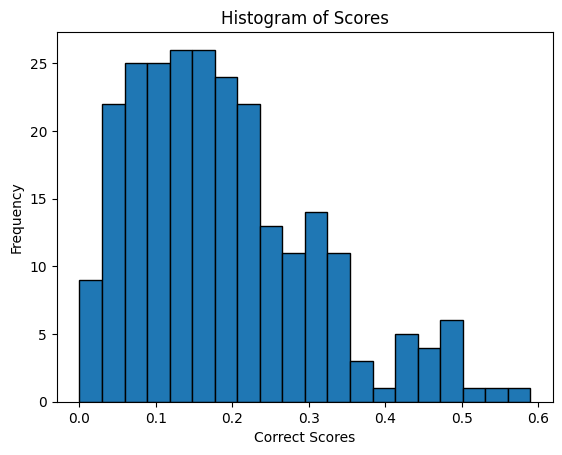

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(correct_scores, bins=20, edgecolor='black')
plt.xlabel('Correct Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Scores')
plt.show()

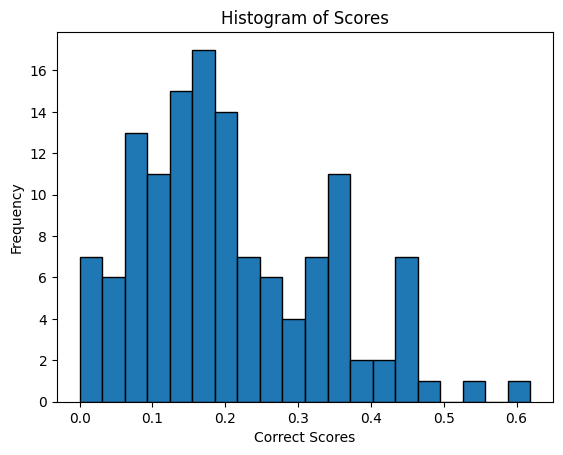

In [29]:
plt.hist(incorrect_scores, bins=20, edgecolor='black')
plt.xlabel('Correct Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Scores')
plt.show()

In [36]:
correct_scores_GPT_Only = []
incorrect_scores_GPT_Only = []

In [49]:
folder_name="Only_GPT_Generated"

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

for i in tqdm(range(130,238), desc="Processing entries", unit="entry"):
    sentences = preprocess_text(dataset["evaluation"][i]["gpt3_text"])
    annotation = dataset["evaluation"][i]["annotation"]
    
    sentences_score, sentence_pairs, sentence_links, sentence_coref_resolved= count_direct_links_and_fraction(sentences)
    
    correct_count = annotation.count("accurate")
    incorrect_count = annotation.count("major_inaccurate")
    total = len(annotation)
    if(correct_count==total):
        correct_scores_GPT_Only.append(sentences_score)
    if(incorrect_count/total>0.80):
        incorrect_scores_GPT_Only.append(sentences_score)
        
    filename = os.path.join(folder_name, f"entry_{i+1}.txt")
    with open(filename, 'w') as file:
        file.write("#############SENTENCE_PAIRS############\n\n")
        for i in range(len(sentence_pairs)):
            file.write(f"{sentence_pairs[i][0]} and {sentence_pairs[i][1]} and the value is : {sentence_links[i]}\n")
        file.write("\n\n")
        file.write("%%%%%%%%%%%%%%%%%%%%SENTENCES%%%%%%%%%%%%%%%%%\n")
        file.write(f"Sentences : \n{sentences} \n\n")
        file.write(f"Coref Resolved : \n{sentence_coref_resolved}")
        file.write("\n\n")
        file.write("%%%%%%%%%%%%%%%%%%%%FRACTIONS%%%%%%%%%%%%%%%%%%\n")
        file.write(f"Value for sentences is : {sentences_score}")
        file.write("\n\n")
        file.write("%%%%%%%%%%%%%%%%%%%%ANNOTATIONS%%%%%%%%%%%%%%%%\n")
        for i in annotation:
            file.write(f"{i} ")
        file.write("\n\n")

Processing entries:   0%|          | 0/108 [00:00<?, ?entry/s]

06/10/2024 14:39:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:39:21 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 16



06/10/2024 14:39:26 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:39:26 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 45



06/10/2024 14:39:31 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:39:31 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 33



06/10/2024 14:39:36 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:39:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 41



06/10/2024 14:39:43 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:39:43 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 72



06/10/2024 14:39:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:39:56 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 121



06/10/2024 14:40:05 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:05 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 31



06/10/2024 14:40:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:11 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 29



06/10/2024 14:40:16 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:17 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 68



06/10/2024 14:40:25 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:25 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 17



06/10/2024 14:40:30 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:30 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 50



06/10/2024 14:40:35 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:35 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 49



06/10/2024 14:40:43 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:43 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 44



06/10/2024 14:40:50 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:50 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 27



06/10/2024 14:40:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:40:56 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 20



06/10/2024 14:41:01 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:02 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 12



06/10/2024 14:41:06 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:06 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 23



06/10/2024 14:41:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:11 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 30



06/10/2024 14:41:17 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:17 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 39



06/10/2024 14:41:23 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 36



06/10/2024 14:41:29 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:29 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 57



06/10/2024 14:41:36 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 19



06/10/2024 14:41:41 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:42 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 11



06/10/2024 14:41:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:47 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 71



06/10/2024 14:41:54 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:41:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 57



06/10/2024 14:42:04 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 39



06/10/2024 14:42:09 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:09 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 17



06/10/2024 14:42:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:15 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 30



06/10/2024 14:42:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:21 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 83



06/10/2024 14:42:28 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:29 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 61



06/10/2024 14:42:36 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 19



06/10/2024 14:42:41 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:41 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 28



06/10/2024 14:42:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:46 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 11



06/10/2024 14:42:51 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:52 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 62



06/10/2024 14:42:58 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:42:59 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 13



06/10/2024 14:43:04 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 41



06/10/2024 14:43:09 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:09 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 26



06/10/2024 14:43:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:15 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 38



06/10/2024 14:43:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:21 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 82



06/10/2024 14:43:28 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:29 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 25



06/10/2024 14:43:34 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:34 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 117



06/10/2024 14:43:43 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:44 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 28



06/10/2024 14:43:49 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:49 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 33



06/10/2024 14:43:55 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:43:55 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 37



06/10/2024 14:44:00 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:00 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 52



06/10/2024 14:44:07 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:07 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 13



06/10/2024 14:44:12 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:12 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 106



06/10/2024 14:44:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:21 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 52



06/10/2024 14:44:28 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:28 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 18



06/10/2024 14:44:33 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:33 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 31



06/10/2024 14:44:38 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:38 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 39



06/10/2024 14:44:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 28



06/10/2024 14:44:50 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:50 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 20



06/10/2024 14:44:55 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:44:56 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 38



06/10/2024 14:45:01 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:01 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 37



06/10/2024 14:45:06 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:06 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 6



06/10/2024 14:45:12 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:12 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 195



06/10/2024 14:45:25 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:26 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 63



06/10/2024 14:45:33 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:33 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 56



06/10/2024 14:45:41 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:41 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 6



06/10/2024 14:45:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:46 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 30



06/10/2024 14:45:51 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:51 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 45



06/10/2024 14:45:57 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:45:57 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 40



06/10/2024 14:46:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:02 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 6



06/10/2024 14:46:07 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:07 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 151



06/10/2024 14:46:17 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:17 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 15



06/10/2024 14:46:23 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 38



06/10/2024 14:46:28 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:28 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 23



06/10/2024 14:46:35 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:35 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 45



06/10/2024 14:46:40 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:40 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 14



06/10/2024 14:46:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 32



06/10/2024 14:46:51 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:51 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 27



06/10/2024 14:46:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:46:56 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 51



06/10/2024 14:47:03 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:03 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 72



06/10/2024 14:47:10 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:10 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 28



06/10/2024 14:47:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:15 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 18



06/10/2024 14:47:20 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:20 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 29



06/10/2024 14:47:26 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:26 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 29



06/10/2024 14:47:31 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:31 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 18



06/10/2024 14:47:36 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 28



06/10/2024 14:47:41 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:41 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 28



06/10/2024 14:47:47 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:47 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 43



06/10/2024 14:47:52 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:52 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 38



06/10/2024 14:47:58 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:47:59 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 47



06/10/2024 14:48:04 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 56



06/10/2024 14:48:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:12 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 35



06/10/2024 14:48:17 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:17 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 43



06/10/2024 14:48:23 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 13



06/10/2024 14:48:28 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:28 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 50



06/10/2024 14:48:34 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:34 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 38



06/10/2024 14:48:40 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:40 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 42



06/10/2024 14:48:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 28



06/10/2024 14:48:52 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:48:52 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 43



06/10/2024 14:49:00 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:49:00 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 31



06/10/2024 14:49:07 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:49:07 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 47



06/10/2024 14:49:13 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:49:13 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 38



06/10/2024 14:49:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:49:21 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 28



06/10/2024 14:49:27 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:49:27 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 16



06/10/2024 14:49:34 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:49:34 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 39



06/10/2024 14:49:40 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:49:40 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 37



06/10/2024 14:49:55 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:49:55 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 63



06/10/2024 14:50:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:50:02 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 10



06/10/2024 14:50:07 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:50:07 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 21



06/10/2024 14:50:13 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:50:13 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 34



06/10/2024 14:50:19 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:50:20 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 25



06/10/2024 14:50:28 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:50:28 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 37



06/10/2024 14:50:36 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:50:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 37



06/10/2024 14:50:43 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/10/2024 14:50:43 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

The number of pairs is: 64



In [50]:
print(correct_scores_GPT_Only)

[0.23214285714285715, 0.4782608695652174, 0.1794871794871795, 0.29545454545454547, 0.038461538461538464, 0.08, 0.08490566037735849, 0.15, 0.037037037037037035, 0.2222222222222222, 0.16666666666666666, 0.16]


In [51]:
print(incorrect_scores_GPT_Only)

[0.11904761904761904, 0.07142857142857142, 0.13157894736842105, 0.06976744186046512, 0.12857142857142856, 0.46153846153846156, 0.21428571428571427, 0.18181818181818182, 0.09090909090909091, 0.2222222222222222, 0.07142857142857142, 0.10256410256410256, 0.0, 0.42424242424242425, 0.16216216216216217, 0.08333333333333333, 0.07407407407407407, 0.3333333333333333, 0.0967741935483871, 0.6190476190476191, 0.10810810810810811, 0.2894736842105263, 0.21428571428571427, 0.4634146341463415, 0.21052631578947367, 0.09090909090909091, 0.2807017543859649, 0.4358974358974359, 0.3170731707317073, 0.42105263157894735, 0.15853658536585366, 0.358974358974359, 0.18421052631578946, 0.13513513513513514, 0.0, 0.0, 0.05555555555555555, 0.26, 0.1891891891891892, 0.3, 0.1891891891891892]


In [52]:
print(sum(correct_scores_GPT_Only)/len(correct_scores_GPT_Only))

0.17705321470121851


In [53]:
print(sum(incorrect_scores_GPT_Only)/len(incorrect_scores_GPT_Only))

0.20293562372079427
